Ovaj primer će demonstrirati korišćenje Keras biblioteke u zadacima regresije. Na osnovu već poznatog skupa podataka Boston Housing koji sadrži informacije o nekretninama, potrebno je napraviti neuronski model koji će predvideti cenu nekretnine. Uz ovo, naučićemo i kako možemo sačuvati naučene modele i kasnije ih upotrebiti. 

Pre nego li počnemo sa radom, uključićemo sve potrebne biblioteke.

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import losses, optimizers
from tensorflow.keras.datasets import boston_housing

In [3]:
import numpy as np
np.random.seed(7)

In [4]:
from matplotlib import pyplot as plt

In [5]:
from sklearn import preprocessing

In [6]:
from sklearn import preprocessing
from sklearn import model_selection

### Korak 1: Priprema skupa podataka

Prvo ćemo učitati skup podataka. Iskoristićemo *Boston housing* skup podataka Keras biblioteke dostupan kroz `dataset` modul koji objedinjuje nekoliko poznatih skupova podataka. Generisani skupovi za treniranje i testiranje su veću u formi `numpy` nizova.

In [7]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data(test_split = 0.33)

In [8]:
X_train.shape

(339, 13)

In [9]:
X_test.shape

(167, 13)

Nakon učitavanja, podatke ćemo i standardizovati.

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Korak 2: Kreiranje mreže

Mreža koju ćemo napraviti će biti mreža sa propagacijom unapred. Imaće ulazni sloj, jedan skriveni sloj sa 100 neurona i izlazni sloj. Broj neurona ulaznog sloja odgovara broju atributa skupa podataka (13). Broj neurona izlaznog sloja je 1 jer mreža treba da predvidi cenu nekretnine. Za aktivacionu funkciju prvog sloja odabraćemo relu, dok ćemo za drugi, izlazni sloj, ostaviti podrazumevanu linearnu aktivaciju a(x)=x koja je standardni izbor u slučajevima regresionih zadataka. Druge aktivacione funkcije bi ograničavale opsege koje mreža može da nauči što je u suprotnosti sa očekivanjima regresionih zadataka. 

In [11]:
number_of_features = X_train.shape[1]
output_size = 1

In [12]:
model = Sequential([
    Input(shape=(number_of_features, )), 
    Dense(units=100, activation='relu'),
    Dense(units=output_size)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


### Korak 3: Treniranje mreže

Prilikom treniranja mreže odabraćemo za funkciju greške srednjekvadratnu grešku (engl. mean squared error). Takođe, možemo pratiti i srednju apsolutnu grešku (engl. mean absolute error). Adam ćemo odabrati kao optimizator.

In [14]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Mrežu ćemo trenirati koristeći paketiće veličine 32 instance u 100 epoha.

In [15]:
history = model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=0)

### Korak 4: Evaluacija mreže

In [16]:
epochs = history.epoch

In [17]:
loss = history.history['loss']
mea = history.history['mae']

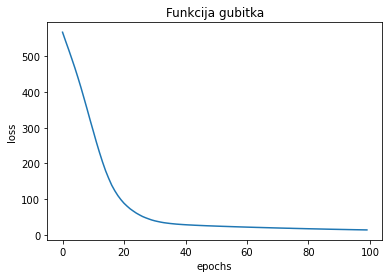

In [18]:
plt.title('Funkcija gubitka')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, loss)

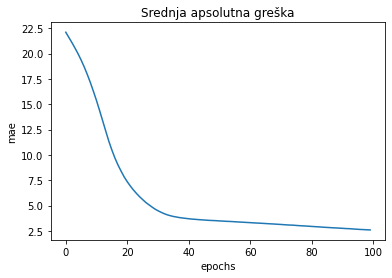

In [19]:
plt.title('Srednja apsolutna greška')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.plot(epochs, mea)

In [20]:
test_mse, test_mae = model.evaluate(X_test, y_test)
print ("Test MSE: {}, Test MEA: {}".format(test_mse, test_mae))

6/6 [==============================] - 0s 2ms/step - loss: 18.6065 - mae: 3.2597
Test MSE: 18.60654640197754, Test MEA: 3.259661912918091


In [21]:
train_mse, train_mae = model.evaluate(X_train, y_train)
print ("Test MSE: {}, Test MEA: {}".format(train_mse, train_mae))

11/11 [==============================] - 0s 1ms/step - loss: 13.8420 - mae: 2.5913
Test MSE: 13.842002868652344, Test MEA: 2.591317892074585


Ukoliko su nam potrebne i druge metrike evaluacije, možemo iskoristiti funkcije biblioteke `scikit-learn`.

In [22]:
from sklearn import metrics

In [23]:
y_predicted = model.predict(X_test)

In [24]:
metrics.r2_score(y_predicted, y_test)

0.7463678089215022

Keras biblioteka omogućava i definisanje funkcija sa povratnim pozivom (engl. callback functions) kojima se mogu pratiti željene vrednosti na nivou pojedinačnih paketića ili celih epoha. Prilikom opredeljivanja za praćenje ovih metrika treba uzeti u obzir to da li su globalnog ili lokalnog karaktera i da li ih ima smisla uporosečavati u krajnju vrednost ili ne. Na primer, srednjekavadratna greška se može pratiti na nivou paketa i na kraju uprosečiti, dok to ne važi za koeficijent determinacije. 

Sledeći primer ilustruje definisanje omotača koji koristi predefinisane funkcije `on_train_begin` i `on_batch_end`. Slično njima, postoje i funkcije `on_train_end` i `on_batch_begin`, kao i funkcije koje se tiču praćenja epoha `on_epoch_begin` i `on_epoch_end`. Gde je primenljivo, ove funkcije imaju i pridruženi paketić sa podacima (parametar `batch`). Parametar `logs` koji se pominje je trenutno fiktivnog karaktera i uvek ga treba postaviti na {}.

In [25]:
from tensorflow.keras import callbacks

In [26]:
model.metrics_names

['loss', 'mae']

In [27]:
class RegressionHistory(callbacks.Callback):
    # predefinisana funkcija koja ce se izvrsiti na pocetku treniranja
    def on_train_begin(self, logs={}):
        self.mse = []

    # predefinisana funkcija koja ce se izvrsiti na kraju obrade svakog od paketica
    def on_batch_end(self, batch, logs={}):
        self.mse.append(logs.get('loss'))

In [28]:
regression_history = RegressionHistory()

In [29]:
history = model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=0, callbacks=[regression_history])

Izračunatu metriku, srednjekvadratnu grešku, na nivou svakog paketića možemo dobiti preko niza `regression_history.mse`. 

In [30]:
len(regression_history.mse)

1100

In [31]:
np.average(regression_history.mse)

10.06590132561597

### Korak 5: Čuvanje modela

Kao što smo napomenuli, za svaki sloj mreže postoji matrica parametara i matrica slobodnih članova. Sve ove matrice se čuvaju u listi `weights` naučenog modela.

In [32]:
weights = model.weights

In [33]:
len(weights)

4

In [34]:
for i in range(0, len(weights)): 
    print(weights[i].shape)

(13, 100)
(100,)
(100, 1)
(1,)


Izračunate matrice parametara je moguće sačuvati funkcijom `save_weights` i kasnije upotrebiti. Za čuvanje se može koristiti hdf5 (Hierarchical Data Format version 5) koji podržava čuvanje velikih, kompleksnih i heterogenih podataka.

In [35]:
model.save_weights('models/boston_housing_weights.hdf5')

Konfiguracija samog modela, se, takođe, može pročitati, sačuvati i po potrebi, kasnije iskoristiti.

Ceo model, uključujući i konfiguraciju i matrice parametara, se može sačuvati funkcijom `save`. Ovo je naročito zgodno kada treniranje mreže treba prekinuti i ponovo nastaviti.

In [36]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 13),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 100,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config

In [37]:
model.save('models/boston_housing.hdf5')

Ceo model, uključujući i konfiguraciju i matrice parametara, se može ponovo pročitati i aktivirati funkcijom `load_model` paketa `models`.

In [38]:
from tensorflow.keras.models import load_model

In [39]:
model_revived = load_model('models/boston_housing.hdf5')

Na primer, informacije o korišćenom optimizatoru se mogu dobiti preko svojstva `optimizer` i funkcije `get_config`.

In [40]:
model_revived.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

Učitani model se može koristiti na način na koji smo to do sada i radili. 

In [41]:
model_revived.predict(np.random.rand(number_of_features).reshape(1, -1))

array([[5.522293]], dtype=float32)

Zajednica koja se bavi mašinskim učenjem ulaže napore da standardizuje formate za čuvanje mreža. Jedan od njih je i [ONNX](https://onnx.ai/) za koji Keras biblioteka nudi [podršku](https://github.com/onnx/onnx-docker/blob/master/onnx-ecosystem/converter_scripts/keras_onnx.ipynb). O ovim temam će svakako biti više reči i u nastavku kursa.

Ukoliko nam je potreban uvid u samu arhitekturu mreže, možemo generisati i grafički prikaz korišćenjem pomoćnih funkcionalnosti biblioteke keras. Za ova generisanja nam je potrebna i bibliteka `graphviz`.

In [42]:
from tensorflow.keras import utils

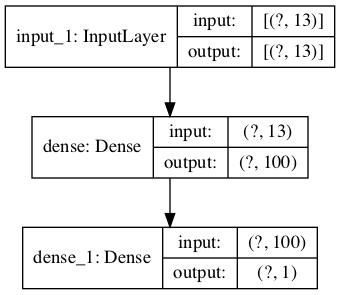

In [43]:
utils.plot_model(model, to_file='model_keras_regresija.png', show_shapes=True)

Na grafiku su prikazana podrazumevana imena slojeva. Adekvatnija imena se mogu zadati svojstvom `name`. 

Vizuelizacije mreže će biti moguće i kroz alat TensorBoard koji ćemo, takođe, upoznati na nekom od narednih časova.